In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from bendable_gan import BendedGenerator
from bending_modules import BendingConvModule, BendingCPPN
from losses import compute_diversity_loss
from utils import generate_image, image_grid
from clip import TextPrompt

%load_ext autoreload
%autoreload 2

c:\Users\giaco\anaconda3\envs\giatorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\giaco\anaconda3\envs\giatorch\lib\site-packages\kornia\augmentation\augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
c:\Users\giaco\anaconda3\envs\giatorch\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
c:\Users\giaco\anaconda3\envs\giatorch\lib\site-packages\torch\utils\tensorboard\__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [ ]:
vanillagen = BendedGenerator.from_pretrained("ceyda/butterfly_cropped_uniq1K_512")

In [ ]:
generate_image(vanillagen)

In [ ]:
numchans = [1024, 1024, 512, 256, 128, 64, 6]

bending_idx = 5

bendingmod = BendingConvModule(numchans[bending_idx])

In [ ]:
device = 'cuda'

bend_generator = BendedGenerator.from_pretrained("ceyda/butterfly_cropped_uniq1K_512",
                                                 bending_module=bendingmod,
                                                 bending_idx=bending_idx,
                                                 train_bending=True)
bend_generator = bend_generator.to(device)

In [ ]:
torch.cuda.empty_cache()

batch_size = 16
tgt_img = torch.tensor(np.array(Image.open('sea.jpg'))).permute(2,0,1).float()/255.
tgt_img = T.Resize(size=(512, 512))(tgt_img)
tgt_img = tgt_img.flatten()
tgt_img = tgt_img.unsqueeze(0).repeat(batch_size, 1).to(device)
n_iter = 1000

opt = Adam(bendingmod.parameters(), 1e-3)

loss_log = []

for i in tqdm(range(n_iter)):
    
    out = bend_generator(torch.randn(batch_size, bend_generator.latent_dim, device=device))
    out = out.clamp_(0., 1.).reshape(batch_size, -1)
        

    loss = F.mse_loss(out, tgt_img)
    loss_log.append(loss.detach().cpu().numpy())

    with torch.no_grad():
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    
plt.plot(range(n_iter), loss_log)   

In [ ]:
exampleimgs = [generate_image(bend_generator) for _ in range(16)]

In [ ]:
image_grid(exampleimgs, 4, 4)

## CLIP Loss

In [ ]:
# Create new bending module to optimize
# with CLIP loss

numchans = [1024, 1024, 512, 256, 128, 64, 6]

bending_idx = 5

bendingmod_clip = BendingConvModule(numchans[bending_idx])

bend_generator_clip = BendedGenerator.from_pretrained("ceyda/butterfly_cropped_uniq1K_512",
                                                 bending_module=bendingmod_clip,
                                                 bending_idx=bending_idx,
                                                 train_bending=True)
bend_generator_clip = bend_generator_clip.to(device)

tgt_text = 'Neon Genesis Evangelion particle system'
text_prompt = TextPrompt(tgt_text, device=device)

In [ ]:
torch.cuda.empty_cache()

batch_size = 16

n_iter = 1000

opt = Adam(bendingmod_clip.parameters(), 1e-4)

loss_log = []

for i in tqdm(range(n_iter)):
    
    noise_input = torch.randn(batch_size, 
                    bend_generator_clip.latent_dim, 
                    device=device)
    
    out = bend_generator_clip(noise_input)
    out = out.clamp_(0., 1.)
        

    loss = text_prompt(out)
    loss_log.append(loss.detach().cpu().numpy())

    with torch.no_grad():
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    
plt.plot(range(n_iter), loss_log)   

In [ ]:
exampleimgs = [generate_image(bend_generator_clip) for _ in range(16)]
image_grid(exampleimgs, 4, 4)

## CPPN

In [2]:
numchans = [1024, 1024, 512, 256, 128, 64, 6]
inputsizes = [8, 16, 32, 64, 128, 256, 512]
bending_idx = 5

cppnmod_clip = BendingCPPN(numchans[bending_idx], inputsizes[bending_idx])

In [3]:
device = 'cuda'

bend_gen_cppn_clip = BendedGenerator.from_pretrained("ceyda/butterfly_cropped_uniq1K_512",
                                                 bending_module=cppnmod_clip,
                                                 bending_idx=bending_idx,
                                                 train_bending=True)
bend_gen_cppn_clip = bend_gen_cppn_clip.to(device)

tgt_text = 'Neon Genesis Evangelion particle system'
text_prompt = TextPrompt(tgt_text, device=device)

100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


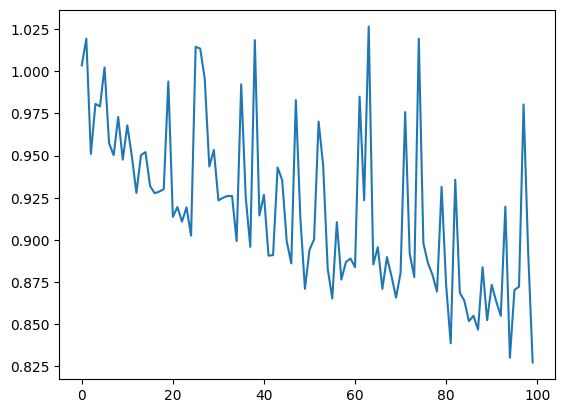

In [4]:
torch.cuda.empty_cache()

batch_size = 16

n_iter = 100

opt = Adam(bend_gen_cppn_clip.parameters(), 1e-4)

loss_log = []

for i in tqdm(range(n_iter)):
    
    noise_input = torch.randn(batch_size, 
                    bend_gen_cppn_clip.latent_dim, 
                    device=device)
    
    out = bend_gen_cppn_clip(noise_input)
    out = out.clamp_(0., 1.)
        

    loss = text_prompt(out)
    loss_log.append(loss.detach().cpu().numpy())

    with torch.no_grad():
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    
plt.plot(range(n_iter), loss_log)   

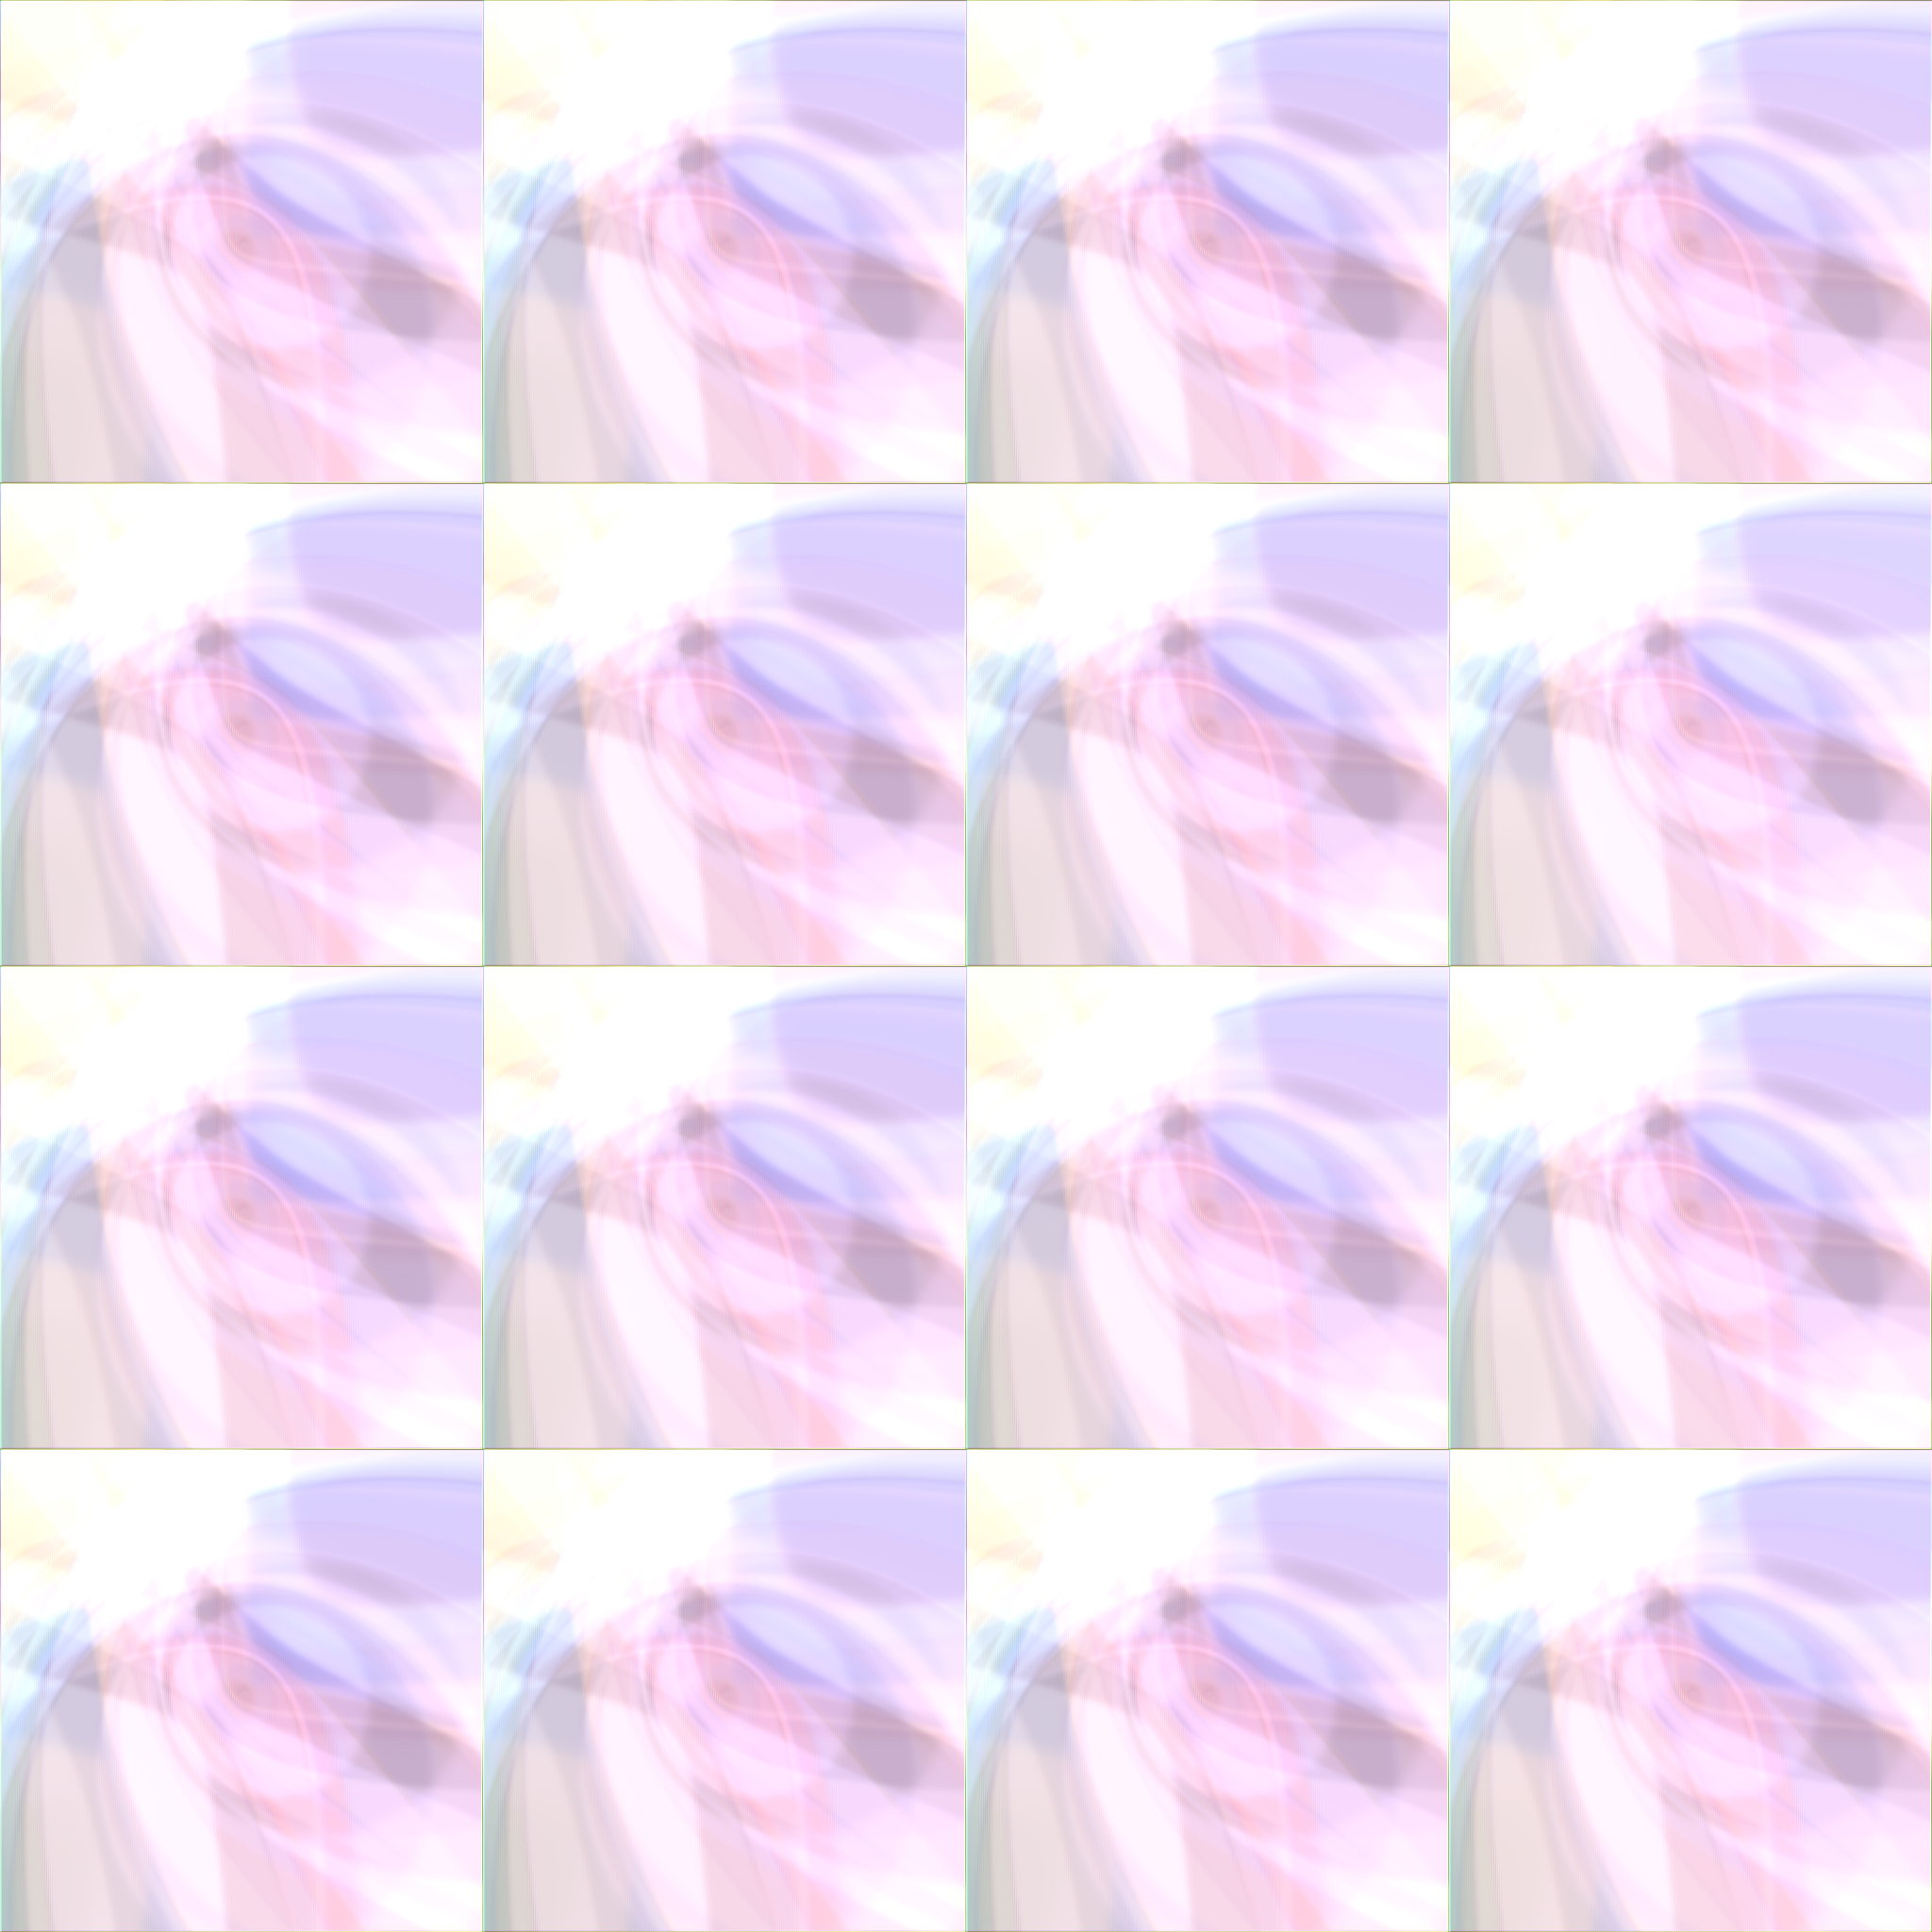

In [5]:
bend_gen_cppn_clip = bend_gen_cppn_clip.to('cpu')
exampleimgs = [generate_image(bend_gen_cppn_clip) for _ in range(16)]
image_grid(exampleimgs, 4, 4)